# <center>Adios 3 Spreading & Related Weathering<center>

### <center>From Bill's document dated June 2016<center>

## <u>Background Discussion & Assumptions</u>

Adios3, like Adios2, only models the spread of dark oil, i.e. oil that is at least 100 microns or thicker.  The assumption is that this represents the major mass of the slick and sheen oil can be neglected.  Because of this assumption, Adios area predictions will not match radar observations of surface oil.

Oil spreads or converges on the water surface due to buoyancy differences (Fay spreading), horizontal dispersion of surface water, wind transport, shoreline interaction, and surface water convergences (Langmuir effects).  For most spills, a rapid initial area of the slick is formed by gravitational slumping (Fay gravity-inertial spreading).  This is followed by slower gravity spreading (Fay gravity-viscous spreading), circular dispersion and stretching along the direction of the wind.  Gradually the slick breaks into wind rows due to Langmuir forces.

Slick spreading can be represented as an Eulerian process (Lehr et al, 1984) or a Lagrangian process (Koziy and Maderich, 2003).  Figure 1 gives the preference between the two methods in modeling the spreading processes.

![Figure 1](Adios3_Spreading_Figure_1.png)<br>
<center>Figure 1</center>

ASA and Adios2 use Lagrangian methods and then deal with Eulerian impact in different ways (ASA=spillets; Adios2=Thiessian polygons).  Both of these approaches have drawbacks.  Thiessian polygons are computationally intensive and spillets ignore global spill forces.  Adios3 will track the movements of the surface oil as a collection of LEs that individually contain information of surface oil thickness.  Each LE will represent a certain volume of oil along with this given thickness but not an individual area.  Total slick area will be computed as needed as a function of the sum of individual LE properties.  Global forces such as shorelines will require some gridding of LEs.

LEs will initially have a thickness assigned based upon the end of Fay gravity-inertial spreading and then further reduced by Fay gravity-viscous spreading.  This latter spreading stops at a minimum thickness dependent upon initial oil viscosity.

$$
\begin{align}
v_0 &= \text{initial oil kinematic viscosity} (m^2/s) \cr
\cr
\delta_{th} &= 10^{-4} m \text{ if } v_0 \geq 10^{-4} m^2 / s \cr
\delta_{th} &= 10^{-5} m \text{ if } v_0 \leq 10^{-6} m^2 / s \cr
\delta_{th} &= 10^{-5} m + 0.1(v_0 - 10^{-6}) \qquad \{ 10^{-6} \leq v_0 \leq 10^{-4} \} \cr
\end{align}
$$

In [97]:
import numpy as np
from numbers import Number

from pylab import *
%matplotlib inline

def get_minimum_thickness(initial_kvis):
    v_0 = initial_kvis

    if isinstance(v_0, Number):
        if v_0 >= 1e-4:
            delta_th = 1e-4
        elif v_0 <= 1e-6:
            delta_th = 1e-5
        else:
            delta_th = 1e-5 + 0.1 * (v_0 - 1e-6)
    else:
        delta_th = 0.0

    return delta_th

initial_kvis = (1e-3, 1e-4, 1e-5, 1e-6, 1e-7)
for kvis in initial_kvis:
    print get_minimum_thickness(kvis)

0.0001
0.0001
1.09e-05
1e-05
1e-05


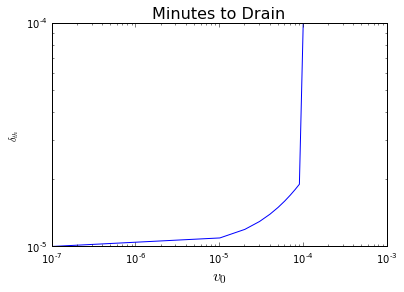

In [101]:
ax = subplot(111)

x = initial_kvis = np.linspace(1e-7, 1e-3, 100)

#y = get_minimum_thickness(initial_kvis)
y = [get_minimum_thickness(k) for k in initial_kvis]

plot(x, y, linewidth=1)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')

plt.title(r'Minutes to Drain', fontsize=16)
plt.xlabel(r'$v_0$', fontsize=16)
plt.ylabel(r'$\delta_{th}$')

show()

This approach is adequate for forecasting weathering processes since, surprisingly, slick area has little impact on other weathering processes.  It is a secondary process in the Thibodeaux dissolution model and is not a factor in dispersion, emulsification, sedimentation, or biodegradation.  Only evaporation is affected, with most, but not all, models assuming a nearly linear relationship between evaporation rate and slick surface area.

## <u>Spreading in Adios3</u>

Adios3 will take advantage of the relatively large LE numbers needed for a Gnome run and, if appropriate, stay with a complete Lagrangian approach.  Each LE will move in a random direction in such a fashion that the LE boundaries will match approximately the Eulerian spreading formula.  If, however, the LEs contain individually large amounts of oil, it may be necessary to calculate spread factors separately for each LE.

### Rapid Spill Case:

In the rapid spill case, the oil is presumed to spill within a few time steps.  Based on the simple leaking tank model in Adios2:

$$
\begin{align}
V_{oil} &= \text{oil volume spill rate} \cr
A_{hole} &= \text{area of hole} \cr
g &= \text{gravitational acceleration} (9.80665 \, m/s^2) \cr
??? &= \text{volume of oil in vessel} \cr
\cr
V_{oil} &= 0.6 A_{hole} \sqrt{2 g \Delta h} \cr
&\cong 0.8 A_{hole} \sqrt{g \cdot V_{oil}^{1/6}} \cr
\end{align}
$$

where the ship or tank is treated as a full cube with a hole at the bottom.

<b><i>(Note: Are the variables in this equation right???  Not intuitive.)</i></b>

Assuming a $1 m^2$ hole then we get the following graph and integrating both sides allows the time $T_{drain}$ to drain the vessel as:

$$
\begin{align}
T_{drain}(min) &\simeq {1 \over 125} V_0^{5/6} \cr
\end{align}
$$

In [19]:
def min_time_to_drain_in_minutes(volume):
    return 1.0 / 125.0 * volume ** (5.0 / 6.0)

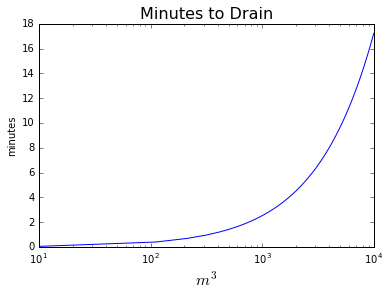

In [28]:
ax = subplot(111)

x = vols = np.linspace(1e1, 1e4, 100)
y = min_time_to_drain_in_minutes(vols)

plot(x, y, linewidth=1)
ax.set_xscale("log", nonposx='clip')

plt.title(r'Minutes to Drain', fontsize=16)
plt.xlabel(r'$m^3$', fontsize=16)
plt.ylabel(r'minutes')

show()

Of course, real accidents would likely involve smaller, less regular holes and would include water ingestion, slowing the process.  As a rule of thumb, Adios3 will assume that a rapid spill will involve the following criteria:

<ul>
    <li>If $V_{oil} < 1000 \, bbl$, then $T_{drain}$ will be the larger of 1 time step or 15 minutes. </li>
    <li>If $1000 < V_{oil} < 10000 \, (bbl)$, then $T_{drain}$ will be the larger of 1 time step or 1 hour. </li>
    <li>If $V_{oil} > 10000 \, bbl$, then $T_{drain}$ will be the larger of 1 time step or 2 hours. </li>
</ul>

For a rapid spill, the slick will spread quickly, due to Fay gravity inertial spreading.  This will occur, according to Dodge et al (1983), at time $T_0$, where:

$$
\begin{align}
v_w &= \text{water kinematic viscosity} \, 1 m^2 / s \cr
\Delta\rho &= \text{relative oil-water density difference} \cr
\cr
T_0 &= 0.4 \root 3 \of {V_{oil} \over v_w \cdot g \cdot \Delta\rho} \cr
\end{align}
$$

Assuming some realistic values for oil density we get:

$$
\begin{align}
T_0 &= {V_{oil}^{1/3} \over 2} \cr
\end{align}
$$

In [30]:
def end_of_gravity_inertial_spreading(volume_in_bbls):
    return volume_in_bbls ** (1.0 / 3.0) / 2.0

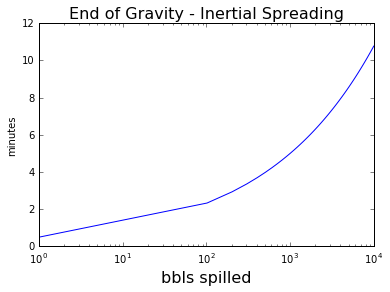

In [34]:
ax = subplot(111)

x = vols = np.linspace(1e0, 1e4, 100)
y = end_of_gravity_inertial_spreading(vols)

plot(x, y, linewidth=1)
ax.set_xscale("log", nonposx='clip')

plt.title(r'End of Gravity - Inertial Spreading', fontsize=16)
plt.xlabel(r'bbls spilled', fontsize=16)
plt.ylabel(r'minutes')

show()

The time frames are on the order of, and somewhat smaller than, the time it takes to leak out of the vessel.  Hence the restrictions on leakage time and assignment of initial thickness remain the same.  The initial (circular) area of the slick is given by:

$$
\begin{align}
A_0 &\simeq {16 \left( V_0^5 g \Delta\rho \over v_w^2 \right)^{1/6} } \cr
\end{align}
$$

The end (of Fay inertial spreading) thickness $\delta_0$ is uniform across the whole slick and is equal to the volume of the spill divided by the initial area:

$$
\begin{align}
\delta_0 &= {V_0 \over A_0} \cr
&\simeq {V_0 \over {16 \left( V_0^5 g \Delta\rho \over v_w^2 \right)^{1/6} }} \cr
&\simeq {V_0 \over {16 { V_0^{5/6} g^{1/6} \Delta\rho^{1/6} \over v_w^{2/6}}}} \cr
&\simeq {V_0 \cdot v_w^{2/6} \over {16 { V_0^{5/6} g^{1/6} \Delta\rho^{1/6} }}} \cr
&\simeq {V_0^{1 - 5/6} \cdot v_w^{2/6} \over {16 { g^{1/6} \Delta\rho^{1/6} }}} \cr
&\simeq {V_0^{1/6} \cdot v_w^{2/6} \over {16 { g^{1/6} \Delta\rho^{1/6} }}} \cr
&\simeq {1 \over 16} \cdot \left(V_0 \cdot v_w^2 \over g \Delta\rho \right)^{1/6} \cr
\end{align}
$$

In [35]:
def end_of_inertial_spreading_thickness(vol_in_sq_meters, delta_rho):
    g = 9.80665  # m/s^2
    v_w = 1e-6  # viscosity of water at 20C (m^2/s)
    V_0 = vol_in_sq_meters
    
    return 1.0 / 16.0 * (V_0 * v_w ** 2.0 / g * delta_rho) ** (1.0 / 6.0)

Assuming realistic values for oil density we get the following plot for LE initial thickness:

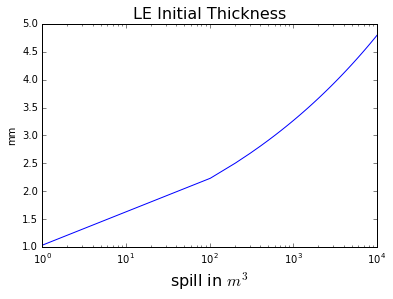

In [42]:
ax = subplot(111)

delta_rho = 1000.0 - 800.0  # in kg/m^3
x = vols = np.linspace(1e0, 1e4, 100)
y = end_of_inertial_spreading_thickness(vols, delta_rho) * 1000  # to get millimeters

plot(x, y, linewidth=1)
ax.set_xscale("log", nonposx='clip')

plt.title(r'LE Initial Thickness', fontsize=16)
plt.xlabel(r'spill in $m^3$', fontsize=16)
plt.ylabel(r'mm')

show()

<b><i>(Note: Looking at Bill's results, I seem to be off by a factor of 1/10.  Need to verify this with Bill.)</i></b>

This same thickness value is assigned to each LE at time $T_0$.  The LE locations will be randomly assigned over the domain $A_0$ with the exception noted below.  The initial volume of each LE, $vLE_0$, will be given by:

$$
\begin{align}
N_{LE} &= \text{the number of LEs released at time} \, T_0 \cr
\cr
vLE_0 &= {V_0 \over N_{LE}} \cr
\end{align}
$$

![Figure 2](Adios3_Spreading_Figure_2.png)<br>
<center>Figure 2</center>

### Exception:

If the area $A_0$ is such that it overlaps land, e.g. a spill next to the shoreline, then reduce $A_0$ appropriately (subtract the land portion), move the initial LE locations to the water side, and increase the initial LE thickness based on the reduced area (initial LE volume remains unchanged).

![Figure 3](Adios3_Spreading_Figure_3.png)<br>
<center>Figure 3</center>

### Continuous Spill Case:

We can have a continuous spill under two circumstances:
<ol>
<li>Continuous spill from a fixed location</li>
<li>Spill from a moving vessel</li>
</ol>

Both cases require modification of Fay gravity intertial spreading since this spreading assumes an instantaneous spill.  Ideally, we want the initial area to be determined by the leak rate and environmental conditions, not the size of the time step.  From the figure that follows eq. 1.7, Fay gravity inertial spreading is of the order or smaller than a typical Gnome/Adios time step.  This means that for most spill rates, it is acceptable to distribute the new LEs released in that time step over an area given by eq. 1.8 where $V_0 = V_0 \Delta t$, $t$ is the time step, and $V_0$ is the volume leak rate.  However, depending upon the oil transport vector and the flow rate, the spilled oil may tend to pile up at the source.

#### <center>Case 1: Fixed Spill Location</center>

The user enters a leak rate $V_0$ and a duration of the leak, which is a multiple of $J$ time steps such that:

$$
\begin{align}
J \cdot \Delta t &= \Delta T \cr
\end{align}
$$

Define $\bar U_{10}$ as the average wind speed over the time period $\Delta T$.  According to Fay (1971), linear spread velocity of the leading edge of the slick, $u_{edge}$, is given by:

$$
\begin{align}
u_{edge} &= \sqrt { \lambda g \Delta \rho {V_0 \over A_0}} \qquad \qquad (eq. 1.7)\cr
\end{align}
$$

while the oil is transported downwind at an average drift velocity of 3% of $\bar U_{10}$.  Assuming a linear reduction in the edge velocity during inertial spreading, set $\lambda = 4$.

<ul>
<li>if $U_{edge} < 0.03 \bar U_{10}$, then each batch of LEs released at time step $j$ will be distributed randomly over an area $A_0$ that can either be a circle or a square.</li>
<li>if $U_{edge} > 0.03 \bar U_{10}$, then the oil piles up and the LEs should be distributed over a rectangle of area $A_0$ where the length (direction downwind) is narrowed to $0.03 \bar U_{10} t$ and the width is $A_0 \over 0.03 \bar U_{10} t$</li>
<li>In both circumstances the oil thickness at the end of Fay gravity-inertial spreading is given by $\delta_0 = {V_0 \over A_0}$</li>
</ul>

#### <center>Case 2: Leak From a Moving Vessel</center>

Replace wind transport by the motion of the vessel.  The interface will need to know the vessel speed or the times of the start and end point.

## <u>Spreading of the Slick</u>

Oil spreading is modeled by moving the individual Lagrangian elements.  The three processes included in spreading are:

<ul>
<li>Fay gravity-viscous spreading</li>
<li>Eddy diffusion of surface water</li>
<li>Langmuir processes</li>
</ul>

Fay gravity-viscous spreading and eddy diffusion of the surface water cause the oil to spread uniformly in all directions.  Both predict uniform coverage of the oil on the water surface.  This contrasts with Langmuir processes that cause the oil to collect in bands with open water in between.  It is instructive to compare Fay spreading with eddy-related spreading.  One way to do it is to treat Fay gravity-viscous as if it were a diffusion process and compare relative diffusion coefficients.

### Fay Diffusion:

Following the suggestion of Ahlstrom (1975), Adios2 represented Fay gravity-viscous spreading as a circular diffusion process with the diffusion coefficient being a function of oil density, spill volume, and time:

$$
\begin{align}
D_{Fay} &= 0.1 \root 3 \of { \Delta\rho \cdot g \cdot V_0^2 \over \sqrt{v_w} } \cdot t^{-1/2} \qquad \qquad (eq. 1.8) \cr
&= 0.1 \left( \Delta\rho \cdot g \cdot V_0^2 \over v_w^{1/2} \right)^{1/3} \cdot t^{-1/2} \cr
&\text{in units} \cr
&= 0.1 \left( kg/m^3 \cdot m/s^2 \cdot (m^3)^2 \over (m^2/s)^{1/2} \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg \over m^3} \cdot {m \over s^2} \cdot (m^3)^2 \cdot {1 \over (m^2/s)^{1/2}} \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg \cdot m \cdot m^3 \cdot m^3 \over m^3 \cdot s^2} \cdot {1 \over (m^2/s)^{1/2}} \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg \cdot m \cdot m^3 \cdot m^3 \over m^3 \cdot s^2} \cdot {1 \over (m/s^{1/2})} \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg \cdot m \cdot m^3 \cdot m^3 \over m^3 \cdot s^2} \cdot {s^{1/2} \over m} \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg \cdot m \cdot m^3 \cdot m^3 \cdot s^{1/2} \over m^3 \cdot s^2 \cdot m} \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg \cdot m^3 \cdot s^{1/2} \over s^2 } \right)^{1/3} \cdot s^{-1/2} \cr
&= 0.1 \left( {kg^{1/3} \cdot (m^3)^{1/3} \cdot (s^{1/2})^{1/3} \over (s^2)^{1/3} } \right) \cdot s^{-1/2} \cr
&= 0.1 \left( {kg^{1/3} \cdot m \cdot s^{1/6} \over s^{2/3} } \right) \cdot s^{-1/2} \cr
&= 0.1 \left( {kg^{1/3} \cdot m \cdot s^{1/6} \cdot s^{-1/2} \over s^{2/3} } \right) \cr
&= 0.1 \left( {kg^{1/3} \cdot m \cdot s^{1/6 - 1/2} \over s^{2/3} } \right) \cr
&= 0.1 \left( {kg^{1/3} \cdot m \cdot s^{-2/6} \over s^{2/3} } \right) \cr
&= 0.1 \left( {kg^{1/3} \cdot m \over s^{2/3} \cdot s^{2/6} } \right) \cr
&= 0.1 \left( {kg^{1/3} \cdot m \over s^{2/3 + 1/3} } \right) \cr
&= 0.1 \left( {kg^{1/3} \cdot m \over s} \right) \cr
\end{align}
$$

In [49]:
def fay_gravity_viscous_spreading(volume, delta_rho, time):
    g = 9.80665  # m/s^2
    v_w = 1e-6  # viscosity of water at 20C (m^2/s)
    V_0 = volume
    t = time

    D_fay = (0.1 *
             (delta_rho * g * V_0 ** 2.0 / v_w ** (1.0 / 2.0)) ** (1.0 / 3.0) *
             t ** (-1.0 / 2.0))

    return D_fay


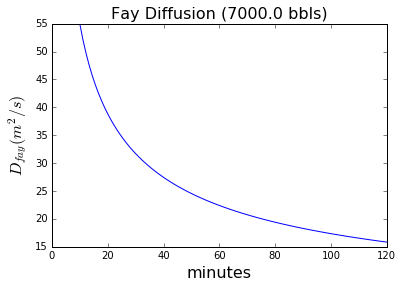

In [70]:
ax = subplot(111)

volume = 7000.0  # bbls
delta_rho = 1000.0 - 800.0  # kg/m^3

x = time = np.linspace(10.0, 120.0, 100)
y = fay_gravity_viscous_spreading(volume * 0.15899,  # bbls -> m^3
                                  delta_rho,
                                  time * 60.0  # min -> sec
                                 )

plot(x, y, linewidth=1)

plt.title(r'Fay Diffusion ({} bbls)'.format(volume), fontsize=16)
plt.xlabel(r'minutes', fontsize=16)
plt.ylabel(r'$D_{fay} (m^2/s)$', fontsize=16)

show()

<b><i>(Note: Looking at Bill's results, I seem to be off by a factor of 40 / 0.017.  Also Bill's graph shows units of $m^2 / s$, and I was expecting units of $kg \cdot m / s$.  Need to verify this with Bill.)</i></b>

### Eddy Diffusion:

Elliot and Hurford (1989) recommended a non-Fickian circular diffusion coefficient to accurately describe eddy diffusion.  As the oil spreads, larger eddies are included in the diffusive processes, causing the diffusion coefficient to slowly increase in time. 

$$
\begin{align}
D_{eddy} &= 0.033 t^{0.16}
\end{align}
$$

In [71]:
def eddy_diffusion_coeff(time):
    D_eddy = 0.033 * time ** 0.16  # I'll bet the 0.16 is actually (1.0 / 6.0)
    return D_eddy

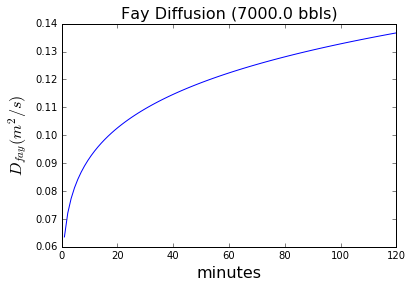

In [72]:
ax = subplot(111)

x = time = np.linspace(1.0, 120.0, 100)
y = eddy_diffusion_coeff(time * 60)

plot(x, y, linewidth=1)

plt.title(r'Fay Diffusion ({} bbls)'.format(volume), fontsize=16)
plt.xlabel(r'minutes', fontsize=16)
plt.ylabel(r'$D_{fay} (m^2/s)$', fontsize=16)

show()

<b><i>(Note: Okay, this is tracking pretty well with Bill's graph.  It gives me confidence that we are at least trying to use seconds as a unit of time)</i></b>

Except for the extremely large spill, eddy diffusion will quickly dominate Fay gravity-viscous spreading.  Therefore, Adios3 will treat Fay spreading as an intrinsic process internal to each LE that leaves the LE location unchanged, while eddy diffusion leaves the LE properties alone but moves the LE.  Note, however, the later discussion of the appropriate coefficients for eddy diffusion.

### Fay Gravity-Viscous Spreading:

Fay gravity-inertial spreading assigns the same initial thickness value $\delta_0$ to each LE.  This thickness reduces by Fay gravity-viscous spreading until a minimum thickness is reached.  Fay gravity-viscous spreading includes water, but not oil, viscosity.  This is counter to our common experience where, for example, motor oil spreads more slowly than gasoline.  At minimum, the model should slow spreading as the oil becomes more viscous over time.  Adopting a modified version of Venkatesh (1988), Adios3 changes standard Fay gravity-viscous spreading to:

$$
\begin{align}
\Delta t &= \text{the model time step} \cr
t_{LE} &= \text{the age of the LE} \cr
\cr
\delta_{LE}(t) &= { \delta_0 \over \sqrt{t_{LE} / \Delta t} } \cdot \left( v_{oil}(t_{LE}) \over v_0 \right)^{1/6} \cr
\end{align}
$$

The viscosity refers to the viscosity of the particular LE, not the average viscosity.  The original Fay formulas include a third spreading phase after gravity-viscous spreading where the driving force is oil-water surface tension.  However, this phase is generally absent for the actual spreading of thick oil in a real spill incident.  Therefore, Adios3 stops Fay spreading at the end of gravity-viscous spreading and assigns a minimum thickness, $\delta_{min}$, to the weathered oil.  The time period for termination of Fay gravity-viscous spreading can be estimated as:

$$
\begin{align}
t_{Fay} &= \left( v_{oil} \over v_0 \right)^{1/3} \cdot \left( \delta_0 \over \delta_{min} \right)^2 \cr
\end{align}
$$

Based upon experimental spill results, Lehr et al (1984) recommend that minimum thickness for crude oils and more viscous refined products $(v_{oil} \geq 100 \, cSt)$ is 0.1 mm.  Small scale experiments in Canada (Venkatesh, 1990) observed higher final thicknesses when oil viscosity was higher.

Assuming that kerosene $(v_{oil} = 10 \, cSt)$ and less viscous products form virtually all sheen with no dark oil (< 10 microns) then, Adios3 will use the following formula to estimate minimum thickness $\delta{min}$ based upon oil viscosity, $v_{oil}$:

<ul>
    <li><b>If</b> $V_{oil} \geq 10^{-4} \, (m^2/s)$, <b>then</b> $\delta_{min} = 10^{-4} \, m$</li>
    <li><b>Else If</b> $V_{oil} \geq 10^{-5} \, (m^2/s)$, <b>then</b> $\delta_{min} = 10^{-5} \, m$</li>
    <li><b>Else</b> $\delta_{min}(m) = v_{oil}(m^2/s)$</li>
</ul>

### Langmuir:

Langmuir processes cause the oil to:
<ul>
    <li>Gather into wind rows</li>
    <li>Move the oil within the wind rows at at faster pace than the average wind drift</li>
<ul>

#### Gathering Into Wind Rows

According to Thorpe (1994) Langmuir cell separation in the open ocean $I_s$ is given by:

$$
\begin{align}
I_s(m) &\simeq {U_{10} + 20 \over 2} \cr
\end{align}
$$

The mean convergence speed $U_c$ between the cells is approximately:

$$
\begin{align}
u_c &= 0.003 U_{10} \cr
\end{align}
$$

making the sweep time for oil to collect in the convergence as:

$$
\begin{align}
\tau_{sweep} &= {I_s \over u_c} \cr
&\simeq {U_{10} + 20 \over 2} \cdot {1 \over 0.003 U_{10}} \cr
&\simeq {U_{10} + 20 \over 2 \cdot 0.003 U_{10}} \cr
&\simeq {U_{10} + 20 \over 0.006 U_{10}} \cr
&\simeq {U_{10} \over 0.006 U_{10}} + {20 \over 0.006 U_{10}} \cr
&\simeq {1 \over 0.006} + {20 \over 0.006 U_{10}} \cr
&\simeq {166.66} + {3333.33 \over U_{10}} \cr
\end{align}
$$

Adios3 needs to estimate the fractional coverage of the surface water caused by the gathering of the oil into wind rows with open water in between.  Using the diagram below, the following non-dimensional variables can be defined.

$$
\begin{align}
\alpha &= {\Delta x \over I_c } \, \{ 0 < \alpha < 1 \}\qquad \qquad (eq. 1.16)\cr
\beta &= {\Delta z \over h_0 } \cr
\end{align}
$$

<ul>
<li><b><i>Note:</i></b> It seems from the description that we want $\alpha$ to be clipped, since it is the result of the formula.<br>  Therefore I would use the notation $\alpha = \left( \Delta x \over I_c \right)_{\top 0}^{\bot 1} $, indicating that we clip the output of the function.</li>
<li><b><i>Note:</i></b> I have no idea what $\Delta x$, $\Delta z$, or $h_0$ are, or how to calculate them.</li>
</ul>

The fractional coverage $f_{cov}$ is given by:

$$
\begin{align}
f_{cov} &= {I_s - \Delta x \over I_s} \qquad \qquad (eq. 1.17)\cr
&= 1 - \alpha \cr
\end{align}
$$

By conservation of oil volume:

$$
\begin{align}
\beta &= {\alpha \over 1 - \alpha} \qquad \qquad (eq. 1.18)\cr
&\text{and...} \cr
\alpha &= {\beta \over 1 + \beta} \cr
\end{align}
$$

By comparing the kinetic energy in the converging oil with the static gravitational energy in the thicker wind row oil, the following heuristic equation (also see eq. 1.20) can be derived:

$$
\begin{align}
\beta &\simeq {v_c^2 \over h_0 \cdot \Delta g} \qquad \qquad (eq. 1.19)\cr
&\text{where...} \cr
\Delta g &= \Delta\rho \cdot g \cr
\end{align}
$$

As an example, consider a typical crude oil spill with the following conditions:

$$
\begin{align}
u_c &= 0.03 \, m/s \cr
h_0 &= 0.0001 \, m \cr
\Delta g &= 2 \, m/s^2 \cr
\end{align}
$$

Then $\beta = 4.5$ and $\alpha = 0.8$

In [73]:
def get_alpha_beta_coeffs(convergence_speed, initial_h, delta_g):
    u_c = convergence_speed
    h_0 = initial_h  # what do we name this exactly???
    
    beta = u_c ** 2.0 / (h_0 * delta_g)
    alpha = beta / (1.0 + beta)
    
    return alpha, beta

print 'alpha = {}, beta = {}'.format(*get_alpha_beta_coeffs(0.03, 0.0001, 2.0))

alpha = 0.818181818182, beta = 4.5


<b><i>Note:</i></b> It seems that based on this verification of results, the actual formula for $\beta$ should be:<br>
$$
\begin{align}
\beta &\simeq {u_c^2 \over h_0 \cdot \Delta g} \cr
\end{align}
$$

![Figure 4](Adios3_Spreading_Figure_4.png)<br>
<center>Figure 4</center>

Equation 1.19 represents a final state where the wind has been blowing consistently long to allow enough time for all the thick oil to collect in wind rows.  However, varying wind direction means that time is needed for new Langmuir cells to form and established wind rows are broken up.  Also, the slick image of an experimental 50 bbl oil spill shown at the beginning of this report demonstrates that wind rows do not form right away for new spills.  Modeling this process in detail is challenging and not justified by the already existing simplifying assujmptions.  Instead, Adios3 will modify equation 1.19 to be:

$$
\begin{align}
\beta &\simeq {v_c^2 \over h_0 \cdot \Delta g} \cdot \min \left\{ 1, {t \over \tau_{sweep} + \tau_{fay}} \right\} \qquad \qquad (eq. 1.20)\cr
\end{align}
$$

where the appropriate 'average' wijnd speed is used to compute $\tau_{sweep}$.

For computational simplicity, Langmuir 'correction' will be applied individually to each LE (assign $h_0 = \delta_{LE}$) who will now have, in addition to a thickness, a fractional coverage parameter as well.

<ul>
<li>LE thickness = $\delta_{LE}$ before Langmuir calculation</li>
<li>LE thickness = $\beta \cdot \delta_{LE}$ after Langmuir calculation</li>
<li>LE fractional coverage = $1$ before Langmuir calculation</li>
<li>LE fractional coverage = $1 - \alpha$ after Langmuir calculation</li>
</ul>

### Reconciling EH and Gnome Diffusion Coefficients:

Gnome has its own diffusion coefficient that is much larger $(1 m^2/s)$ than the non-Fickian diffusion coefficient of Elliot and Hurford (EH).  Eddy coefficients do not scale well and the experiments of EH may not be appropriate to a large real spill.  On the other hand, Gnome diffusion does not accurately represent small spill diffusion.  A compromise solution is to scale the initiaql diffusion coefficient to the initial Fay area and time (Eq's 1.7 and 1.8).  Then the black LE' diffusion coefficient $D_{LE}$ is given by

$$
\begin{align}
D_{LE} &= min \left\{ D_{eddy}, D_{GNOME} \right\} \qquad \qquad (eq. 1.21)\cr
\end{align}
$$

where:

$$
\begin{align}
c_{eddy} &= \text{empirical constant depending on} \cr
&\ \quad \text{spill size and conditions} \cr
\cr
D_{eddy} &= c_{eddy} {A_0 \over T_0} \cdot t^{0.16} \qquad \qquad (eq. 1.22)\cr
\end{align}
$$

Red LE diffusion, representing an increase in our uncertainty in oil location, not the actual dispersion of the oil, does not change.

## <u>Adjusting Area for Overlapping LEs and Computing Total Slick Area</u>

Each LE will include values for the following parameters related to spreading:

<ul>
<li>Initial LE volume</li>
<li>LE volume at time $t$</li>
<li>LE thickness atd time $t$</li>
<li>Minimum LE thickness</li>
<li>Fractional thick oil coverage</li>
</ul>

Notice that individual LE area is NOT an included parameter.  LE area can be computed at any time by dividing LE volume $V_{LE}(t)$ by LE thickness $\delta_{LE}(t)$.  Total slick area $A_{slick}(t)$ could then be computed by summing the calculated LE individual areas.  This is not the area necessarily defined by the actual LE location boundaries.

$$
\begin{align}
A_{slick}(t) &= \sum_{nLE} {V_{LE} \over \delta_{LE}} \qquad \qquad (eq. 1.23)\cr
&\text{and...} \cr
\bar A_{LE} &= { A_{slick} \over nLE } \cr
\end{align}
$$

If LEs are close to each other, as in a spill along a shoreline, then LE thickness adjustment is necessary.  The procedure is as follows:

<ol>
    <li>Grid the spill location area.  Grid boundaries are determined by the four extreme LE locations (east, west north, south).  Grid size is set to the average value of the individual LE areas $\bar A_{LE}$.</li>
    <li>Count the number of LEs, $nLE(j,k)$ in each grid element $j,k$.
        <ol>
            <li>If $nLE(j,k) = \{ 0.1 \}$, then do nothing</li>
            <li>If $nLE(j,k) = M$, where $M > 1$, then
                <ol>
                  <li>for the set {m=1 to M} of LEs located in grid j,k</li>
                  <li>$f_{cov} = min \left\{ \sum_{m=1}^M {f_{cov}(m), 1} \right\}$</li>
                  <li>new $\delta_{LE}(m) = \delta_{LE}(m) \cdot max \left\{ 1, f_{cov} \cdot M \right\}$</li>
                  <li>Oil Volume of each LE remains the same</li>
                </ol>
            </li>
        <ol>
    </li>
<ol>

## <u>Digression Into Evaporation</u>

There are two major competing model systems for mass evaporation rate:

<ol>
    <li>Well-mixed slick where the surface boundary layer controls oil mass evaporation rate, and slick viscosity and thickness are not important.  This is the current approach used in most models.  Adios2, ASA, and SINTEF use a version of the Payne pseudo-component model and S.L. Ross and some of the Europeans use some modification of the Mackay-Stiver single but time-varying component model.</li>
    <li>Diffusion-limited model where the controlling mass loss rate factors are the oil viscosity and thickness.  The Fingas model is an empirical fit version of this model.</li>
</ol>

The Mass transfer Biot number gives an indication which of these two approaches is appropriate for any spill.

$$
\begin{align}
\delta_{oil} &= \text{oil slick thickness} (m) \cr
D_{oil} &= \text{diffusion coefficient} (m^2 / s) \cr
k_w &= \text{air side mass transfer velocity} (m/s) \cr
\cr
N_{Bi} &= {k_w \cdot \delta_{oil} \over D_{oil}} \qquad \qquad (eq. 1.24)\cr
\end{align}
$$

According to Buchanan and Hurford (1988)

$$
\begin{align}
k_w &= 0.0025 U_{10}^{7/9} \qquad \qquad (eq. 1.25)\cr
\end{align}
$$

with $U_{10} =$ wind speed at 10m.  And yes, the units are wrong.  Higher wind speeds will cause sea-spray and an increase in the wind exponent.

Adios3 will use the following approach:

$$
\begin{align}
&\text{if } U_{10} \leq 10 m/s, \text{then:} \qquad \qquad (eq. 1.26)\cr
&\ \qquad K_{evap} = c_{evap} U_{10}^{7/9} \cr
&\text{else:} \cr
&\ \qquad K_{evap} = 0.06 \, c_{evap} U_{10}^{2}
\end{align}
$$

If $K_{evap}$ is expressed in m/s, then Buchanan and Hurford set $c_{evap} = 0.0025$.

In [82]:
from numbers import Number

def get_k_evap(wind_speed):  # need a better description of K_evap
    c_evap = 0.0025  # an evaporation coefficient describing ???

    # the conditional in this function requires a special case
    # for numpy arrays and other sequences.
    if isinstance(wind_speed, Number):
        U_10 = wind_speed
        if U_10 <= 10.0:
            K_evap = c_evap * U_10 ** (7.0 / 9.0)
        else:
            K_evap = 0.06 * c_evap * U_10 ** 2.0
    else:
        # assume it is a sequence in which some elements > 10
        # and some elements are <= 10
        U_10 = np.array(wind_speed)
        K_evap = np.zeros_like(wind_speed)
        leq = U_10 <= 10.0
        gt = leq ^ True

        K_evap[leq] = c_evap * U_10[leq] ** (7.0 / 9.0)
        K_evap[gt] = 0.06 * c_evap * U_10[gt] ** 2.0

    return K_evap

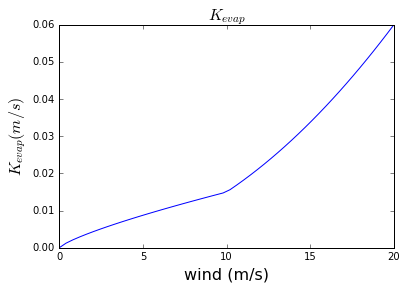

In [91]:
ax = subplot(111)

x = wind_speed = np.linspace(0.0, 20.0, 50)
y = get_k_evap(wind_speed)

plot(x, y, linewidth=1)

plt.title(r'$K_{evap}$', fontsize=16)
plt.xlabel(r'wind (m/s)', fontsize=16)
plt.ylabel(r'$K_{evap} (m/s)$', fontsize=16)

show()

<ul>
<li><b><i>Note:</i></b> Bill's graph has a range of only (0 ... 10), and this graph correlates within that range.  But I would like to see what he would graph for wind speeds greater than 10.</li>
</ul>

According to Hiss and Cussler (1973):

$$
\begin{align}
\eta_{oil} &= \text{the oil dynamic viscosity} \cr
\cr
D_{oil} &\propto \eta_{oil}^{-2/3} \qquad \qquad (eq. 1.27) \cr
\end{align}
$$

However, the same authors note that others find the exponent in the above equation to be unity.  Adios3 could consider the Biot-Fingas number defined as:

$$
\begin{align}
N_{BF} &= {U_{10} \cdot \delta_{oil} \over v_{oil}} \qquad \qquad (eq. 1.28) \cr
\end{align}
$$

A large Biot-Fingas number indicates that a Fingas-type model is the correct choice while a small Biot-Fingas number suggests that Payne is the correct model.  An oil could start out with a small Biot number and then change to a large number if viscosity or thickness greatly increased.  Fingas (2013) has suggested that oil thicker than 2 mm will show diffusion limitations.  Stronach and Hospital (2014) concluded that 7 mm was a more appropriate number.  However, oil spilled on the open sea will not usually form slicks this thick unless it was either highly viscous to begin with or has emulsified.  The Fingas model also, does not provide information on the change in the intrinsic properties of the oil due to evaporation.  In particular, no data is available to estimate changes in relative SARA fraction.  Therefore, Adios3 will not use the Fingas model in its first release.

## <u>Payne Model Assumptions About Area</u>

The Payne model assumes that mass evaporation rate is a linear function of the whole area of the slick.  Adios2 assigned the appropriate Thiessien polygon area to any individual LE when calculating LE specific evaporative mass loss but Adios3 does not use Thiessian polygons.  Instead, it will use the LE volume divided by its thickness.  LEs of equal age, volume, and thickness will have equal evaporative mass loss.

For each LE numbered $\{n_{LE} = 1 ... N_{LE} \}$, there will be $\{ ipc = 1 ... IPC \}$ pseudo components for aromatics and the same number for saturates.  Resins and asphaltenes are assumed to be non-volatile.

Adios3 evaporation will calculate separately the individual LE mass loss rate:

$$
\begin{align}
dm_{LE}(ipc) \over dt
\end{align}
$$

for each pseudo-component.

Robert's notes (Draft Evaporation in Adios3, June 23, 2014) need to be modified as follows:

The mass loss rate per pseudo component $i$ (separate pseudo-components for saturates and aromatics) is modified as:

$$
\begin{align}
{dm_{LE}(ipc) \over dt} = {Vol_{LE} \over \delta_{LE}} \cdot K_{evap} \cdot { Sc_{ipc} \cdot m_{ipc} \cdot Pv_{ipc} \over mw_{ipc} \cdot R \cdot T_w \cdot \sum\limits_{ii=1}^{IPC} { m_{ii} \over mw_{ii}}} \qquad \qquad (eq. 1.29) \cr
\end{align}
$$

If the slick has emulsified, then the right side of eq. 1.29 needs to be multiplied by the fraction of the emulsion that is oil i.e. $(1 - f_w)$.

Note that slick area or downwind diameter are no longer included in the formula.  Definitions of the undefined terms in eq. 1.29 are found in Robert's notes.
Molecular weight calculations use the reference <i>Characterization and Properties of Petroleum Fractions</i>, authored by Dr. M. R. Riazi, Professor of Chemical Engineering at Kuwait University, published in 2005 by American Society for Testing and Materials (ASTM), International, Stock number MNL50

Some checks to make sure the formula is working:

<table>
    <tr>
        <th>Hydrocarbon</th>
        <th>Type</th> 
        <th>Boiling Pt. $(\ ^\circ C)$</th>
        <th>Molecular Weight $(kg/kmol)$</th>
    </tr>
    <tr>
        <td>benzene</td>
        <td>aromatic</td> 
        <td>80</td>
        <td>78</td>
    </tr>
    <tr>
        <td>pentane</td>
        <td>saturate</td> 
        <td>36</td>
        <td>72</td>
    </tr>
</table>

It is important that all terms in equation 1.29 be expressed in the right MKS (IS) units.  For example, molecular weight is in kg/kmol, vapor pressure in Pascals, temperature in Kelvin, and mass evaporation rate in kg/s.

$$
\begin{align}
R &= \text{gas constant} (KJ/kmol \ ^\circ K) \cr
&= 8.314 \cr
\end{align}
$$